# Import statements

Pip installations

In [35]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.3/896.3 kB 16.2 MB/s eta 0:00:00


Import statements

In [63]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adadelta
import cv2
import re
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Directory paths

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
dataset_dir = '/content/drive/MyDrive/Research Files/Other files/Development/Dataset/Dataset'
segmentation_model = YOLO('/content/drive/MyDrive/Research Files/Other files/Development/Dataset/YOLOv8 Trained Model/best.pt')

# Global variables

Difference loss function

In [ ]:
def difference_loss(y_true, y_pred):
    diff_true = y_true[:, 1:] - y_true[:, :-1]
    diff_pred = y_pred[:, 1:] - y_pred[:, :-1]
    return tf.reduce_mean(tf.square(diff_true - diff_pred))

Combined MSE and Difference loss functions

In [ ]:
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))  # MSE
    diff = difference_loss(y_true, y_pred)  # Difference Loss
    return mse + 0.5 * diff  # Adjust weights as needed

Global variables

In [115]:
# tf.data.Dataset
MAX_SEQUENCE_LENGTH = 45
BATCH_SIZE = 4
SHUFFLE_BUFFER_SIZE = 100
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

IMAGE_WIDTH = 291
IMAGE_HEIGHT = 218
IMAGE_CHANNELS = 3

LOSS_FUNCTION = "mse"
# LOSS_FUNCTION = "mae"
# LOSS_FUNCTION = "difference_loss"
# LOSS_FUNCTION = "combined_loss"

LEARNING_RATE = 1.0
OPTIMIZER = Adadelta(learning_rate=LEARNING_RATE)
# LEARNING_RATE = 0.001
# OPTIMIZER = Adam(learning_rate=LEARNING_RATE)

EPOCHS = 50

AUGMENT_PROBABILITY = 1.0  # Ensure augmentation is applied
AUGMENT_PROBABILITY_TEMP = AUGMENT_PROBABILITY  # Save the original value

# Functions

In [64]:
def get_sequences(sequence_dir):
    sequence_paths = sorted(
        [os.path.join(sequence_dir, d) for d in os.listdir(sequence_dir) if os.path.isdir(os.path.join(sequence_dir, d))],
        key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0])
    )
    sequences = []
    for seq_path in sequence_paths:
        frame_paths = sorted(
            glob.glob(os.path.join(seq_path, '*.*')),
            key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0])
        )
        sequences.append(frame_paths)
    return sequences

In [21]:
def create_tf_dataset(sequences):
    dataset = tf.data.Dataset.from_generator(
        lambda: sequence_generator(sequences),
        output_types=tf.string,
        output_shapes=(None,)
    )
    return dataset

In [20]:
def sequence_generator(sequences):
    for sequence in sequences:
        yield sequence

In [70]:
def visualize_sequences(sequences, set_name):
    num_sequences = min(2, len(sequences))  # We want to display up to 2 sequences

    for seq_idx in range(num_sequences):
        sequence = sequences[seq_idx]
        num_frames = min(5, len(sequence))  # Ensure we don't exceed the number of frames in the sequence
        frames = sequence[:num_frames]

        plt.figure(figsize=(15, 5))
        for idx, frame_path in enumerate(frames):
            # Read the image
            img = cv2.imread(frame_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize image for display purposes (e.g., to width=400 pixels)
            scale_factor = 400 / img.shape[1]
            new_width = int(img.shape[1] * scale_factor)
            new_height = int(img.shape[0] * scale_factor)
            display_img = cv2.resize(img, (new_width, new_height))

            # Extract frame number from file name
            frame_number = int(re.findall(r'\d+', os.path.basename(frame_path))[0])

            # Plot the image
            plt.subplot(1, num_frames, idx + 1)
            plt.imshow(display_img)
            plt.title(f'Seq {seq_idx + 1}, Frame {frame_number}')
            plt.axis('off')

        plt.suptitle(f'{set_name} Set - Sequence {seq_idx + 1}')
        plt.show()

In [52]:
def preprocess_image(image_path):
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply segmentation model
    results = segmentation_model.predict(source=img, save=False, verbose=False)

    # Get the segmentation mask
    masks = results[0].masks
    if masks is not None and len(masks.data) > 0:
        # Assuming the first mask is the plant
        mask = masks.data[0].cpu().numpy()  # Shape: (H, W)
        mask = (mask * 255).astype(np.uint8)
    else:
        # If no mask is found, use an empty mask
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    # Ensure the mask has the same size as the image
    if mask.shape != img.shape[:2]:
        print(f"Resizing mask from {mask.shape} to {img.shape[:2]}")
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Apply the mask to the image
    segmented_img = cv2.bitwise_and(img, img, mask=mask)

    # Resize the image
    img_resized = cv2.resize(segmented_img, (IMAGE_WIDTH, IMAGE_HEIGHT))

    # Normalize the image to [0,1]
    img_normalized = img_resized / 255.0

    return img_normalized.astype(np.float32)

In [103]:
def preprocess_image_with_intermediate(image_path):
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply segmentation model
    results = segmentation_model.predict(source=img, save=False, verbose=False)

    # Get the segmentation mask
    masks = results[0].masks
    if masks is not None and len(masks.data) > 0:
        # Assuming the first mask is the plant
        mask = masks.data[0].cpu().numpy()
        mask = (mask * 255).astype(np.uint8)
    else:
        # If no mask is found, use an empty mask
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    # Ensure the mask has the same size as the image
    if mask.shape != img.shape[:2]:
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Apply the mask to the image
    segmented_img = cv2.bitwise_and(img, img, mask=mask)

    # Resize the image
    img_resized = cv2.resize(segmented_img, (IMAGE_WIDTH, IMAGE_HEIGHT))

    # Image before normalization
    img_before_normalization = img_resized.copy()

    # Normalize the image to [0,1]
    img_normalized = img_resized / 255.0

    return img_before_normalization.astype(np.float32), img_normalized.astype(np.float32)

In [29]:
def preprocess_sequence(frame_paths, max_length):
    frames = []
    for frame_path in frame_paths:
        img = preprocess_image(frame_path)
        frames.append(img)
    frames = np.array(frames)

    # Pad or truncate the sequence to 'max_length'
    sequence_length = frames.shape[0]
    if sequence_length < max_length:
        # Pad with zeros at the beginning
        pad_length = max_length - sequence_length
        padding = np.zeros((pad_length, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float32)
        frames = np.concatenate([padding, frames], axis=0)
    else:
        # Truncate the sequence
        frames = frames[-max_length:]
    return frames

In [30]:
def process_sequence_tf(frame_paths):
    frames = tf.py_function(
        func=preprocess_sequence,
        inp=[frame_paths, MAX_SEQUENCE_LENGTH],
        Tout=tf.float32
    )
    frames.set_shape([MAX_SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    return frames

In [31]:
def create_input_target(frames):
    inputs = frames[:-1]   # Exclude the last frame
    targets = frames[1:]   # Exclude the first frame
    return inputs, targets

In [32]:
def augment_sequence(frames):
    """
    Applies random augmentations to a sequence of frames.

    Args:
        frames: Tensor of shape (sequence_length, height, width, channels)

    Returns:
        Augmented frames of the same shape.
    """
    def _augment(frames_np):
        # Decide whether to apply augmentation
        if np.random.rand() < AUGMENT_PROBABILITY:
            # Define augmentation parameters
            # Example: Random flip and rotation
            flip_code = np.random.choice([None, 0, 1, -1])  # None: no flip, 0: vertical, 1: horizontal, -1: both
            angle = np.random.uniform(-15, 15)  # Rotate between -15 to 15 degrees

            # Define the rotation matrix
            if angle != 0:
                center = (IMAGE_WIDTH / 2, IMAGE_HEIGHT / 2)
                rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

            augmented_frames = []
            for frame in frames_np:

                # Apply flip if selected
                if flip_code is not None:
                    frame = cv2.flip(frame, flip_code)

                # Apply rotation if angle is not zero
                if angle != 0:
                    frame = cv2.warpAffine(frame, rotation_matrix, (IMAGE_WIDTH, IMAGE_HEIGHT), borderMode=cv2.BORDER_REFLECT)


                augmented_frames.append(frame)

            augmented_frames = np.array(augmented_frames)
            return augmented_frames.astype(np.float32)
        else:
            # No augmentation applied
            return frames_np

    # Use tf.py_function to apply the augmentation
    augmented_frames = tf.py_function(func=_augment, inp=[frames], Tout=tf.float32)

    # Set the shape
    augmented_frames.set_shape([MAX_SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    return augmented_frames

In [99]:
def augment_sequence_np(frames_np):
    # Decide whether to apply augmentation
    if np.random.rand() < AUGMENT_PROBABILITY:
        # Define augmentation parameters
        flip_code = np.random.choice([None, 0, 1, -1])  # None: no flip, 0: vertical, 1: horizontal, -1: both
        angle = np.random.uniform(-15, 15)  # Rotate between -15 to 15 degrees

        # Define the rotation matrix
        if angle != 0:
            center = (IMAGE_WIDTH / 2, IMAGE_HEIGHT / 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        augmented_frames = []
        for frame in frames_np:
            # Apply flip if selected
            if flip_code is not None:
                frame = cv2.flip(frame, flip_code)

            # Apply rotation if angle is not zero
            if angle != 0:
                frame = cv2.warpAffine(frame, rotation_matrix, (IMAGE_WIDTH, IMAGE_HEIGHT), borderMode=cv2.BORDER_REFLECT)

            augmented_frames.append(frame)

        augmented_frames = np.array(augmented_frames)
        return augmented_frames.astype(np.float32)
    else:
        # No augmentation applied
        return frames_np.astype(np.float32)

In [83]:
def visualize_prepadding(sequence_paths, set_name):
    original_length = len(sequence_paths)
    pad_length = MAX_SEQUENCE_LENGTH - original_length
    print(f"\n{set_name} sequence original length: {original_length}")
    print(f"{set_name} pad length: {pad_length}")

    # Preprocess the sequence (includes prepadding)
    padded_frames = preprocess_sequence(sequence_paths, MAX_SEQUENCE_LENGTH)
    print(f"{set_name} frames shape after padding: {padded_frames.shape}")

    # Visualize the first 5 frames (should be zeros if padded)
    num_frames = 5
    plt.figure(figsize=(15, 5))
    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)
        frame = padded_frames[i]
        plt.imshow(frame)
        plt.title(f'Frame {i + 1} (Padded)')
        plt.axis('off')
    plt.suptitle(f'{set_name} Set - First {num_frames} Frames After Padding')
    plt.show()

    # Visualize the last 5 frames (actual images)
    num_frames = 5
    plt.figure(figsize=(15, 5))
    for i in range(-num_frames, 0):
        plt.subplot(1, num_frames, i + num_frames + 1)
        frame = padded_frames[i]
        frame_idx = i + MAX_SEQUENCE_LENGTH  # Frame index in the padded sequence
        original_frame_idx = frame_idx - pad_length
        frame_path = sequence_paths[original_frame_idx]
        original_frame_number = int(re.findall(r'\d+', os.path.basename(frame_path))[0])
        plt.imshow(frame)
        plt.title(f'Frame {frame_idx + 1}\n(Original Frame {original_frame_number})')
        plt.axis('off')
    plt.suptitle(f'{set_name} Set - Last {num_frames} Frames After Padding')
    plt.show()

In [86]:
def visualize_segmentation(sequence_paths, set_name):
    original_length = len(sequence_paths)
    pad_length = MAX_SEQUENCE_LENGTH - original_length
    num_frames = 5
    frames = sequence_paths[-num_frames:]  # Last 5 frames of the original sequence
    original_frame_numbers = []
    original_images = []
    masks_list = []
    segmented_images = []

    # Preprocess the sequence (includes prepadding)
    padded_frames = preprocess_sequence(sequence_paths, MAX_SEQUENCE_LENGTH)

    # Compute the indices in the padded sequence corresponding to the last 5 frames
    padded_frame_indices = list(range(MAX_SEQUENCE_LENGTH - num_frames, MAX_SEQUENCE_LENGTH))

    for idx, (frame_path, padded_idx) in enumerate(zip(frames, padded_frame_indices)):
        # Load image
        img = cv2.imread(frame_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_images.append(img)

        # Extract original frame number
        frame_number = int(re.findall(r'\d+', os.path.basename(frame_path))[0])
        original_frame_numbers.append(frame_number)

        # Apply segmentation model
        results = segmentation_model.predict(source=img, save=False, verbose=False)

        # Get the segmentation mask
        masks = results[0].masks
        if masks is not None and len(masks.data) > 0:
            # Assuming the first mask is the plant
            mask = masks.data[0].cpu().numpy()  # Shape: (H, W)
            # Convert mask to binary (0 and 255)
            mask = (mask * 255).astype(np.uint8)
        else:
            # If no mask is found, use an empty mask
            mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

        # Ensure the mask has the same size as the image
        if mask.shape != img.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        masks_list.append(mask)

        # Apply the mask to the image
        segmented_img = cv2.bitwise_and(img, img, mask=mask)
        segmented_images.append(segmented_img)

    # Visualize the results
    num_rows = num_frames
    num_cols = 3
    plt.figure(figsize=(15, 3 * num_rows))
    for idx in range(num_frames):
        padded_idx = padded_frame_indices[idx]
        frame_number = original_frame_numbers[idx]

        # Original image
        plt.subplot(num_rows, num_cols, idx * num_cols + 1)
        plt.imshow(original_images[idx])
        plt.title(f'Frame {padded_idx + 1} (Original Frame {frame_number})')
        plt.axis('off')

        # Segmentation mask
        plt.subplot(num_rows, num_cols, idx * num_cols + 2)
        plt.imshow(masks_list[idx], cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')

        # Segmented image
        plt.subplot(num_rows, num_cols, idx * num_cols + 3)
        plt.imshow(segmented_images[idx])
        plt.title('Segmented Image')
        plt.axis('off')

    plt.suptitle(f'{set_name} Set - Segmentation Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()

In [91]:
def visualize_resizing_with_dimensions(sequence_paths, set_name):
    original_length = len(sequence_paths)
    pad_length = MAX_SEQUENCE_LENGTH - original_length
    num_frames = 5
    frames = sequence_paths[-num_frames:]  # Last 5 frames of the original sequence
    original_frame_numbers = []
    original_images = []
    resized_images = []

    # Compute the indices in the padded sequence corresponding to the last 5 frames
    padded_frame_indices = list(range(MAX_SEQUENCE_LENGTH - num_frames, MAX_SEQUENCE_LENGTH))

    for idx, (frame_path, padded_idx) in enumerate(zip(frames, padded_frame_indices)):
        # Load original image
        img_original = cv2.imread(frame_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        original_images.append(img_original)

        # Extract original frame number
        frame_number = int(re.findall(r'\d+', os.path.basename(frame_path))[0])
        original_frame_numbers.append(frame_number)

        # Apply segmentation model
        results = segmentation_model.predict(source=img_original, save=False, verbose=False)

        # Get the segmentation mask
        masks = results[0].masks
        if masks is not None and len(masks.data) > 0:
            # Assuming the first mask is the plant
            mask = masks.data[0].cpu().numpy()
            # Convert mask to binary (0 and 255)
            mask = (mask * 255).astype(np.uint8)
        else:
            # If no mask is found, use an empty mask
            mask = np.zeros((img_original.shape[0], img_original.shape[1]), dtype=np.uint8)

        # Ensure the mask has the same size as the image
        if mask.shape != img_original.shape[:2]:
            mask = cv2.resize(mask, (img_original.shape[1], img_original.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Apply the mask to the image
        segmented_img = cv2.bitwise_and(img_original, img_original, mask=mask)

        # Resize the image
        img_resized = cv2.resize(segmented_img, (IMAGE_WIDTH, IMAGE_HEIGHT))
        resized_images.append(img_resized)

    # Visualize the images with dimensions
    num_rows = num_frames
    num_cols = 2  # Original and Resized images
    plt.figure(figsize=(12, 4 * num_rows))
    for idx in range(num_frames):
        frame_number = original_frame_numbers[idx]
        padded_idx = padded_frame_indices[idx]

        # Original image with dimensions
        plt.subplot(num_rows, num_cols, idx * num_cols + 1)
        plt.imshow(original_images[idx])
        plt.title(f'Original Frame {frame_number}\nDimensions: {original_images[idx].shape[1]}x{original_images[idx].shape[0]}')
        plt.xlabel('Width (pixels)')
        plt.ylabel('Height (pixels)')
        plt.xticks(np.linspace(0, original_images[idx].shape[1], 5))
        plt.yticks(np.linspace(0, original_images[idx].shape[0], 5))
        plt.grid(True)

        # Resized image with dimensions
        plt.subplot(num_rows, num_cols, idx * num_cols + 2)
        plt.imshow(resized_images[idx])
        plt.title(f'Resized Frame {padded_idx + 1}\nDimensions: {IMAGE_WIDTH}x{IMAGE_HEIGHT}')
        plt.xlabel('Width (pixels)')
        plt.ylabel('Height (pixels)')
        plt.xticks(np.linspace(0, IMAGE_WIDTH, 5))
        plt.yticks(np.linspace(0, IMAGE_HEIGHT, 5))
        plt.grid(True)

    plt.suptitle(f'{set_name} Set - Resizing Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()

In [96]:
def visualize_normalization(sequence_paths, set_name):
    # Get the last frame from the sequence
    frame_path = sequence_paths[-1]

    # Preprocess the image to get both before and after normalization images
    img_before_norm, img_after_norm = preprocess_image_with_intermediate(frame_path)

    # Get pixel values at a specific position
    pixel_position = (200, 120)  # Top-left corner
    pixel_values_before = img_before_norm[pixel_position[1], pixel_position[0]]
    pixel_values_after = img_after_norm[pixel_position[1], pixel_position[0]]

    print(f"\n{set_name} Set - Pixel Values at {pixel_position}:")
    print(f"Before Normalization: {pixel_values_before}")
    print(f"After Normalization: {pixel_values_after}")

    # Visualize the images
    plt.figure(figsize=(10, 5))

    # Before normalization
    plt.subplot(1, 2, 1)
    plt.imshow(img_before_norm.astype(np.uint8))
    plt.title('Before Normalization')
    plt.axis('off')

    # After normalization
    plt.subplot(1, 2, 2)
    plt.imshow(img_after_norm)
    plt.title('After Normalization')
    plt.axis('off')

    plt.suptitle(f'{set_name} Set - Normalization Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()

In [100]:
def visualize_data_augmentation(sequence_paths, set_name):
    original_length = len(sequence_paths)
    pad_length = MAX_SEQUENCE_LENGTH - original_length
    num_frames = 5

    # Preprocess the sequence (includes prepadding)
    frames = preprocess_sequence(sequence_paths, MAX_SEQUENCE_LENGTH)

    # Get the last 5 frames (actual images)
    original_frames = frames[-num_frames:]

    # Apply augmentation
    augmented_frames = augment_sequence_np(original_frames)

    # Visualize the original and augmented images
    plt.figure(figsize=(15, 6))
    for idx in range(num_frames):
        # Original image
        plt.subplot(2, num_frames, idx + 1)
        plt.imshow(original_frames[idx])
        plt.title(f'Original Frame {MAX_SEQUENCE_LENGTH - num_frames + idx + 1}')
        plt.axis('off')

        # Augmented image
        plt.subplot(2, num_frames, num_frames + idx + 1)
        plt.imshow(augmented_frames[idx])
        plt.title(f'Augmented Frame {MAX_SEQUENCE_LENGTH - num_frames + idx + 1}')
        plt.axis('off')

    plt.suptitle(f'{set_name} Set - Data Augmentation Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()

# Import dataset

## Load dataset

Load dataset

In [73]:
train_sequences_dir = os.path.join(dataset_dir, 'train_set')
val_sequences_dir = os.path.join(dataset_dir, 'val_set')
test_sequences_dir = os.path.join(dataset_dir, 'test_set')

In [74]:
train_sequences = get_sequences(train_sequences_dir)
val_sequences = get_sequences(val_sequences_dir)
test_sequences = get_sequences(test_sequences_dir)

In [75]:
train_dataset = create_tf_dataset(train_sequences)
val_dataset = create_tf_dataset(val_sequences)
test_dataset = create_tf_dataset(test_sequences)

Verify if dataset has been loaded

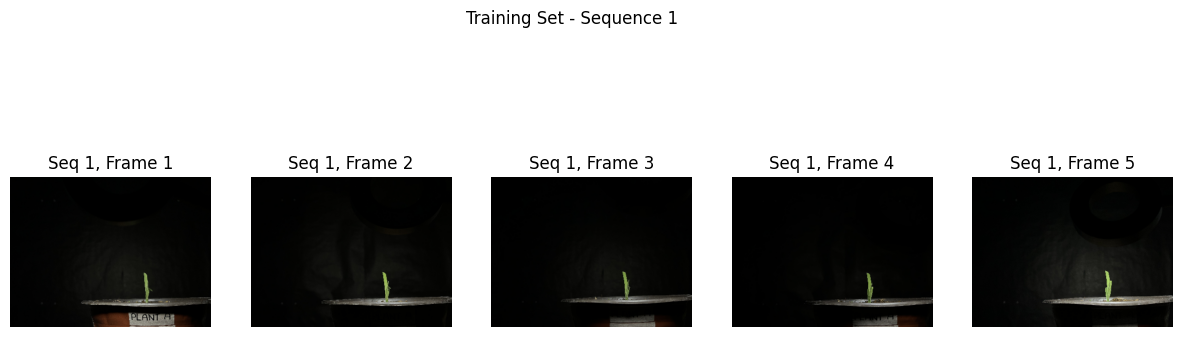

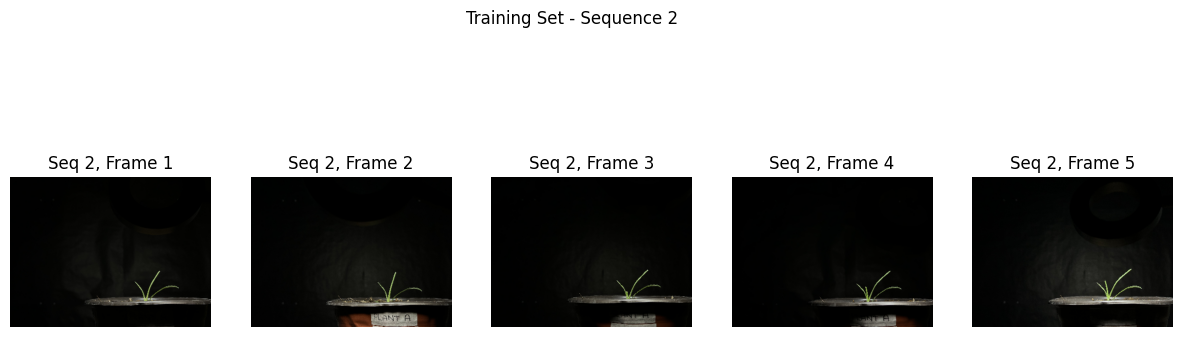

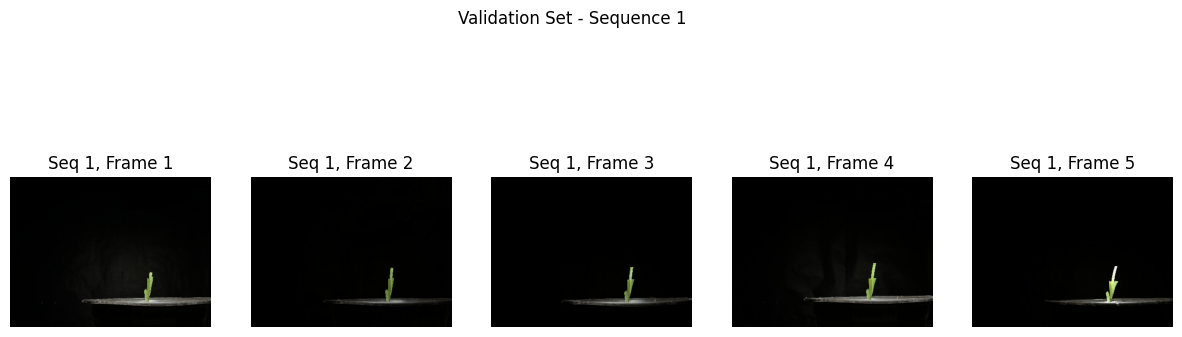

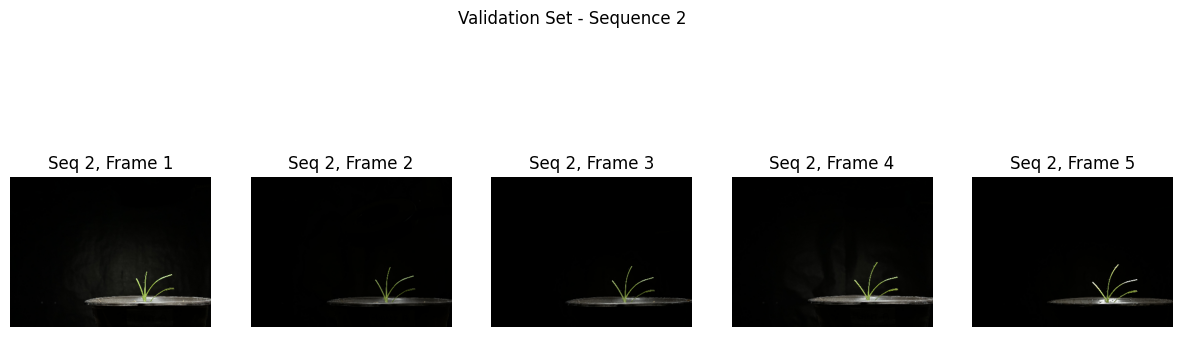

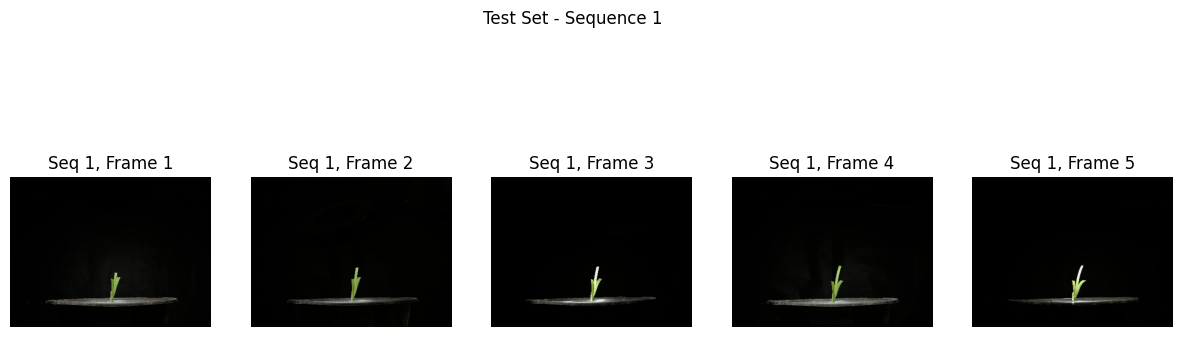

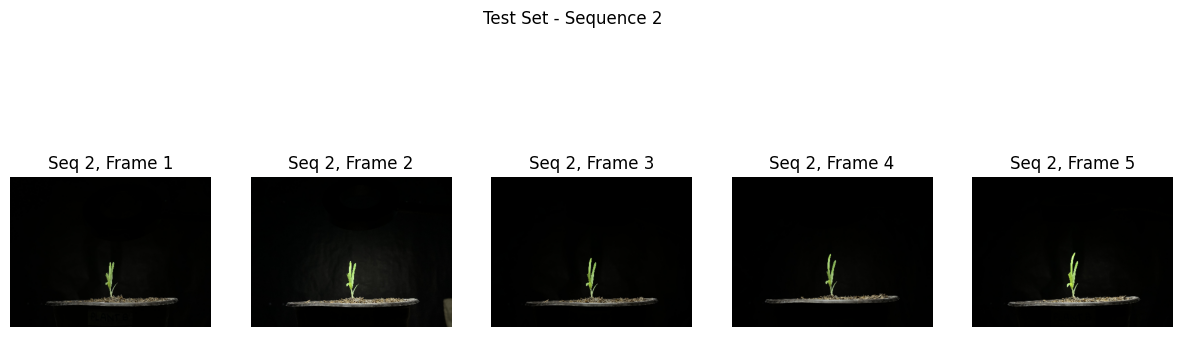

In [76]:
# Visualize sequences from the training set
visualize_sequences(train_sequences, 'Training')

# Visualize sequences from the validation set
visualize_sequences(val_sequences, 'Validation')

# Visualize sequences from the test set
visualize_sequences(test_sequences, 'Test')

# Apply pre-padding + Segment plant object + Preprocess dataset

In [77]:
train_dataset = train_dataset.map(process_sequence_tf, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(process_sequence_tf, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(process_sequence_tf, num_parallel_calls=tf.data.AUTOTUNE)

In [101]:
# Apply data augmentation only to the training set
train_dataset = train_dataset.map(lambda x: augment_sequence(x), num_parallel_calls=tf.data.AUTOTUNE)

In [104]:
train_dataset = train_dataset.map(create_input_target, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(create_input_target, num_parallel_calls=tf.data.AUTOTUNE)

In [105]:
train_dataset = (
    train_dataset
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

val_dataset = (
    val_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

test_dataset = (
    test_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

Verify if data has been preprocessed successfully

1. Pre-padding


Training sequence original length: 24
Training pad length: 21
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask fro

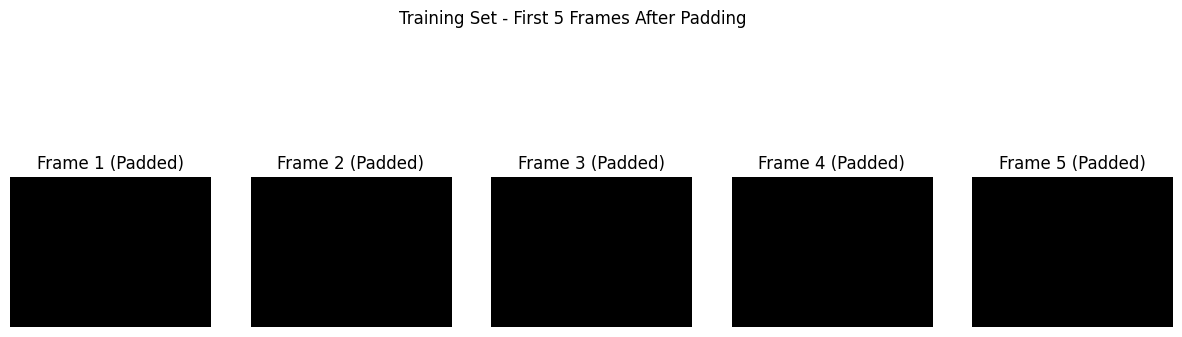

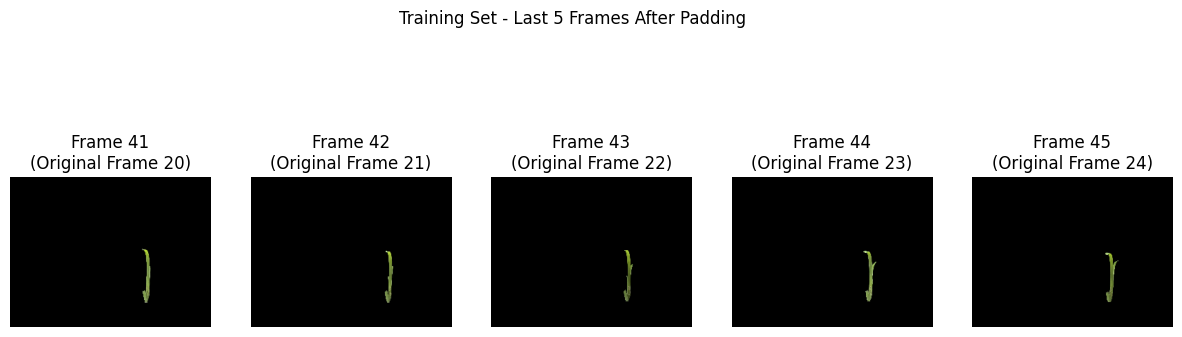


Validation sequence original length: 31
Validation pad length: 14
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask

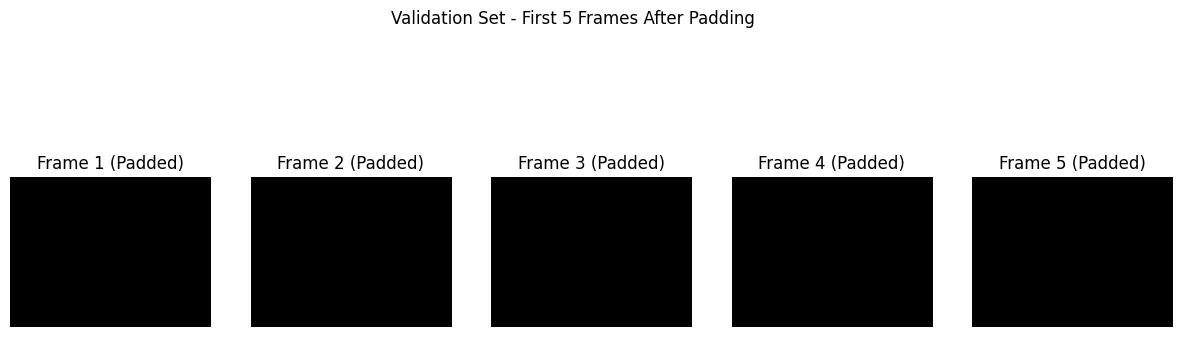

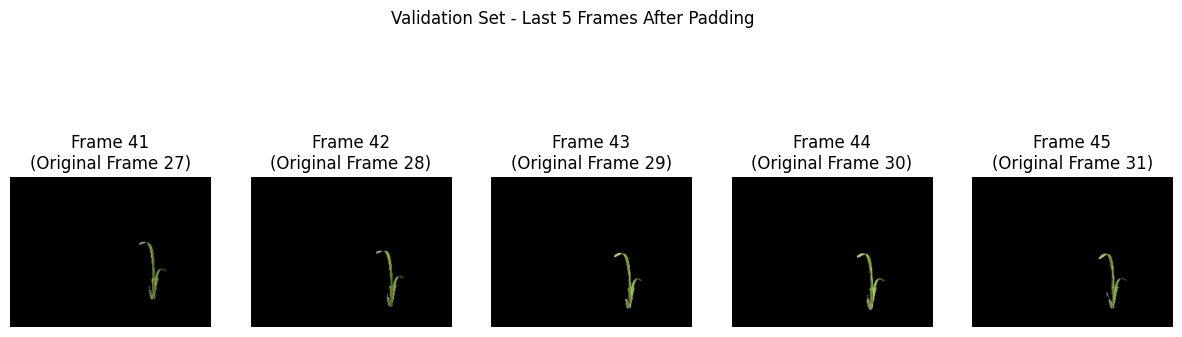


Test sequence original length: 31
Test pad length: 14
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 

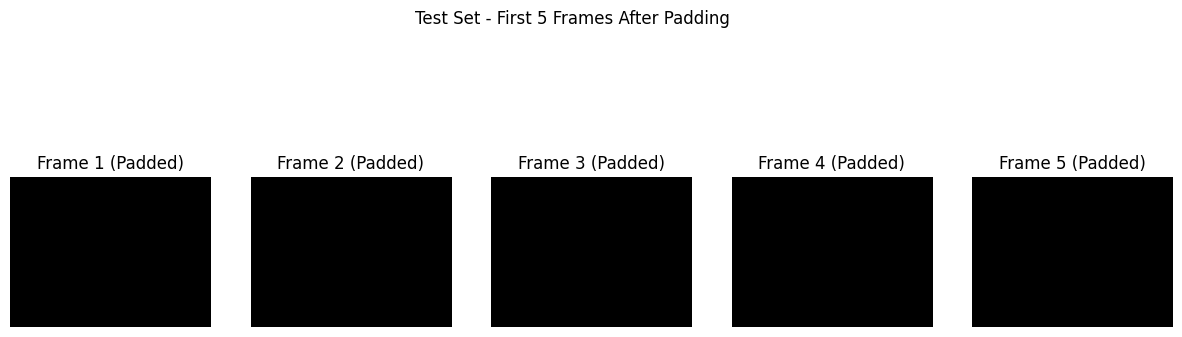

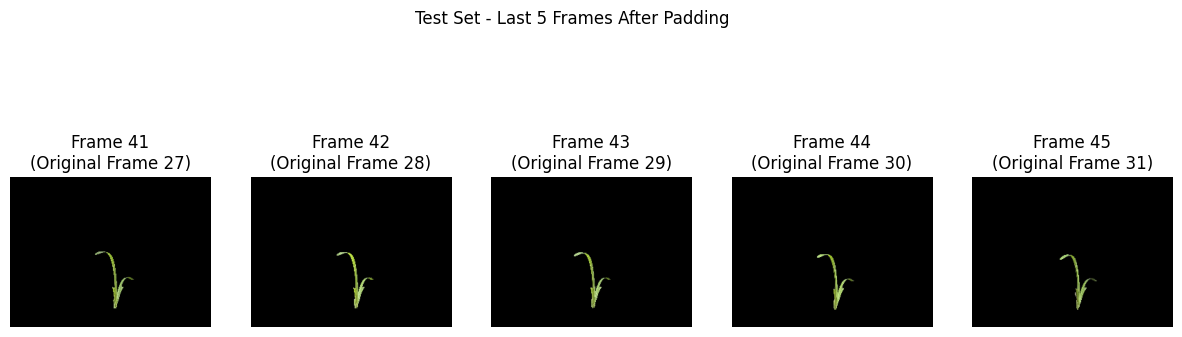

In [84]:
# Select sequences shorter than MAX_SEQUENCE_LENGTH from each dataset
short_train_sequences = [seq for seq in train_sequences if len(seq) < MAX_SEQUENCE_LENGTH]
short_val_sequences = [seq for seq in val_sequences if len(seq) < MAX_SEQUENCE_LENGTH]
short_test_sequences = [seq for seq in test_sequences if len(seq) < MAX_SEQUENCE_LENGTH]

# Ensure there are sequences to visualize
if len(short_train_sequences) == 0 or len(short_val_sequences) == 0 or len(short_test_sequences) == 0:
    print("No sequences shorter than MAX_SEQUENCE_LENGTH found in one of the datasets.")
else:
    # Visualize prepadding for the training set
    visualize_prepadding(short_train_sequences[0], 'Training')

    # Visualize prepadding for the validation set
    visualize_prepadding(short_val_sequences[0], 'Validation')

    # Visualize prepadding for the test set
    visualize_prepadding(short_test_sequences[0], 'Test')

2. Segmentation

Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (

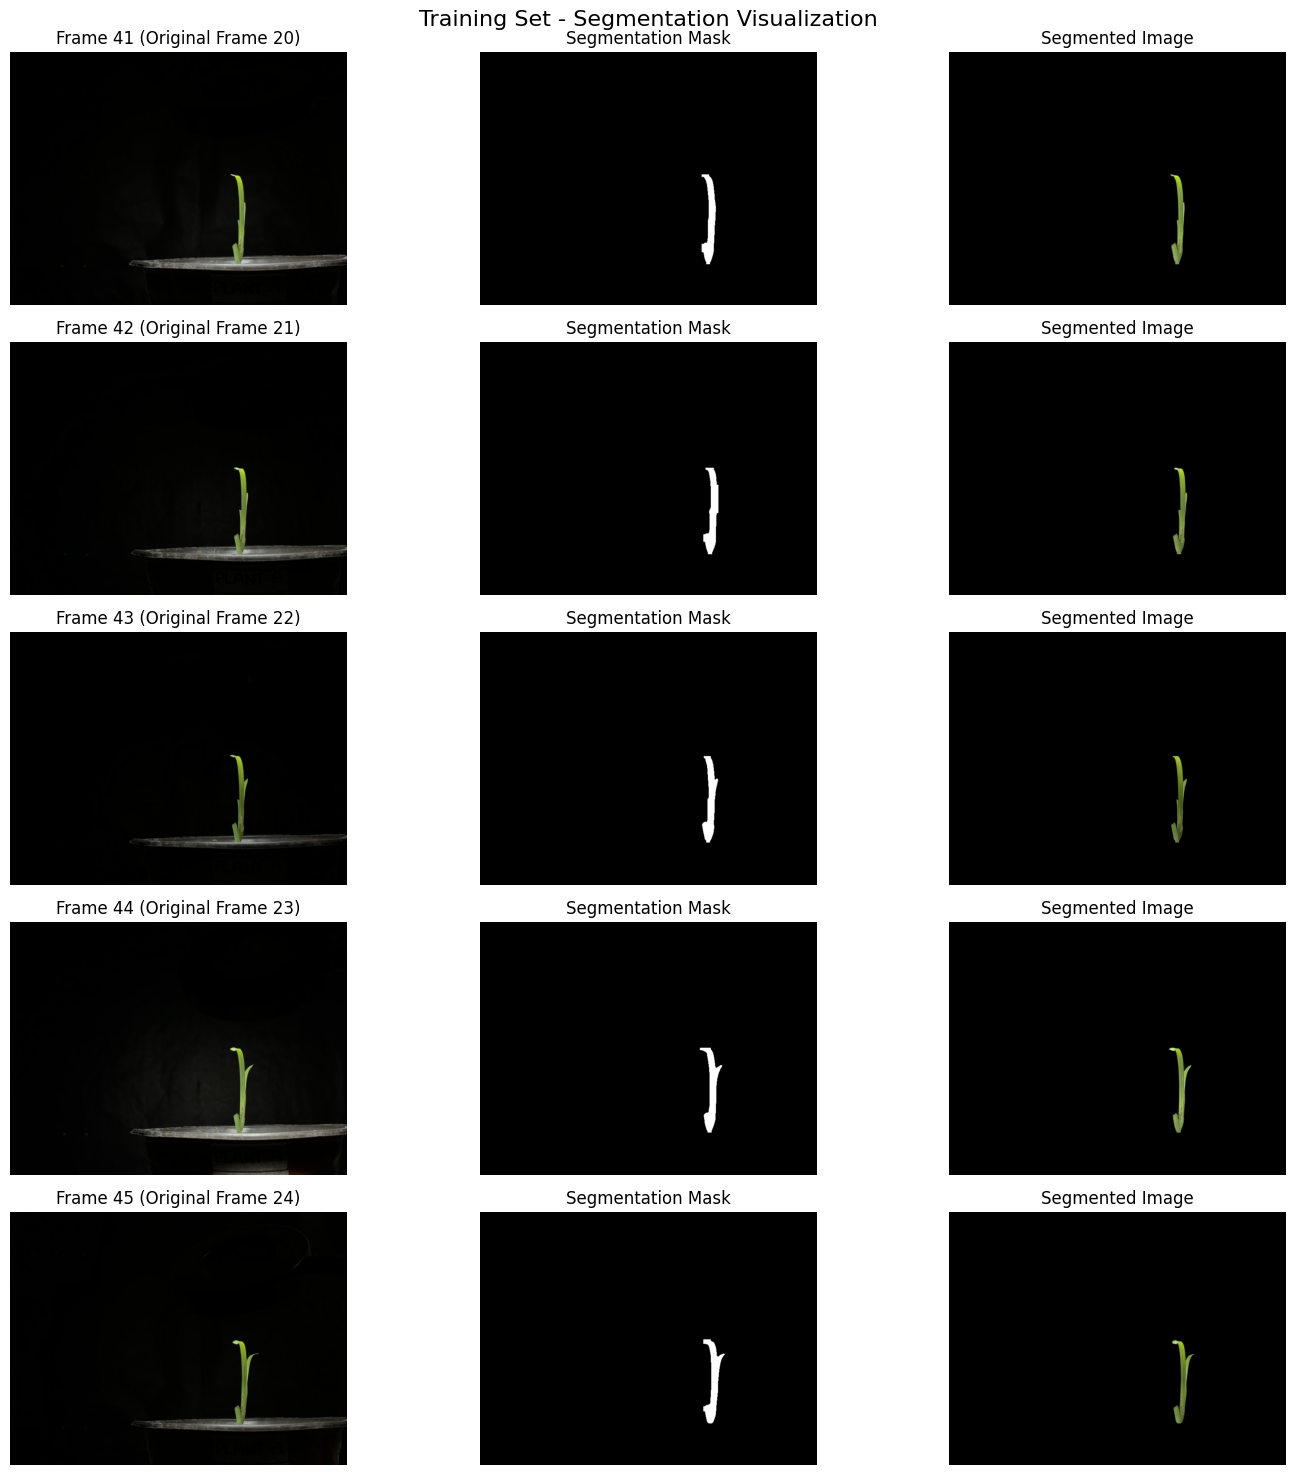

Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (

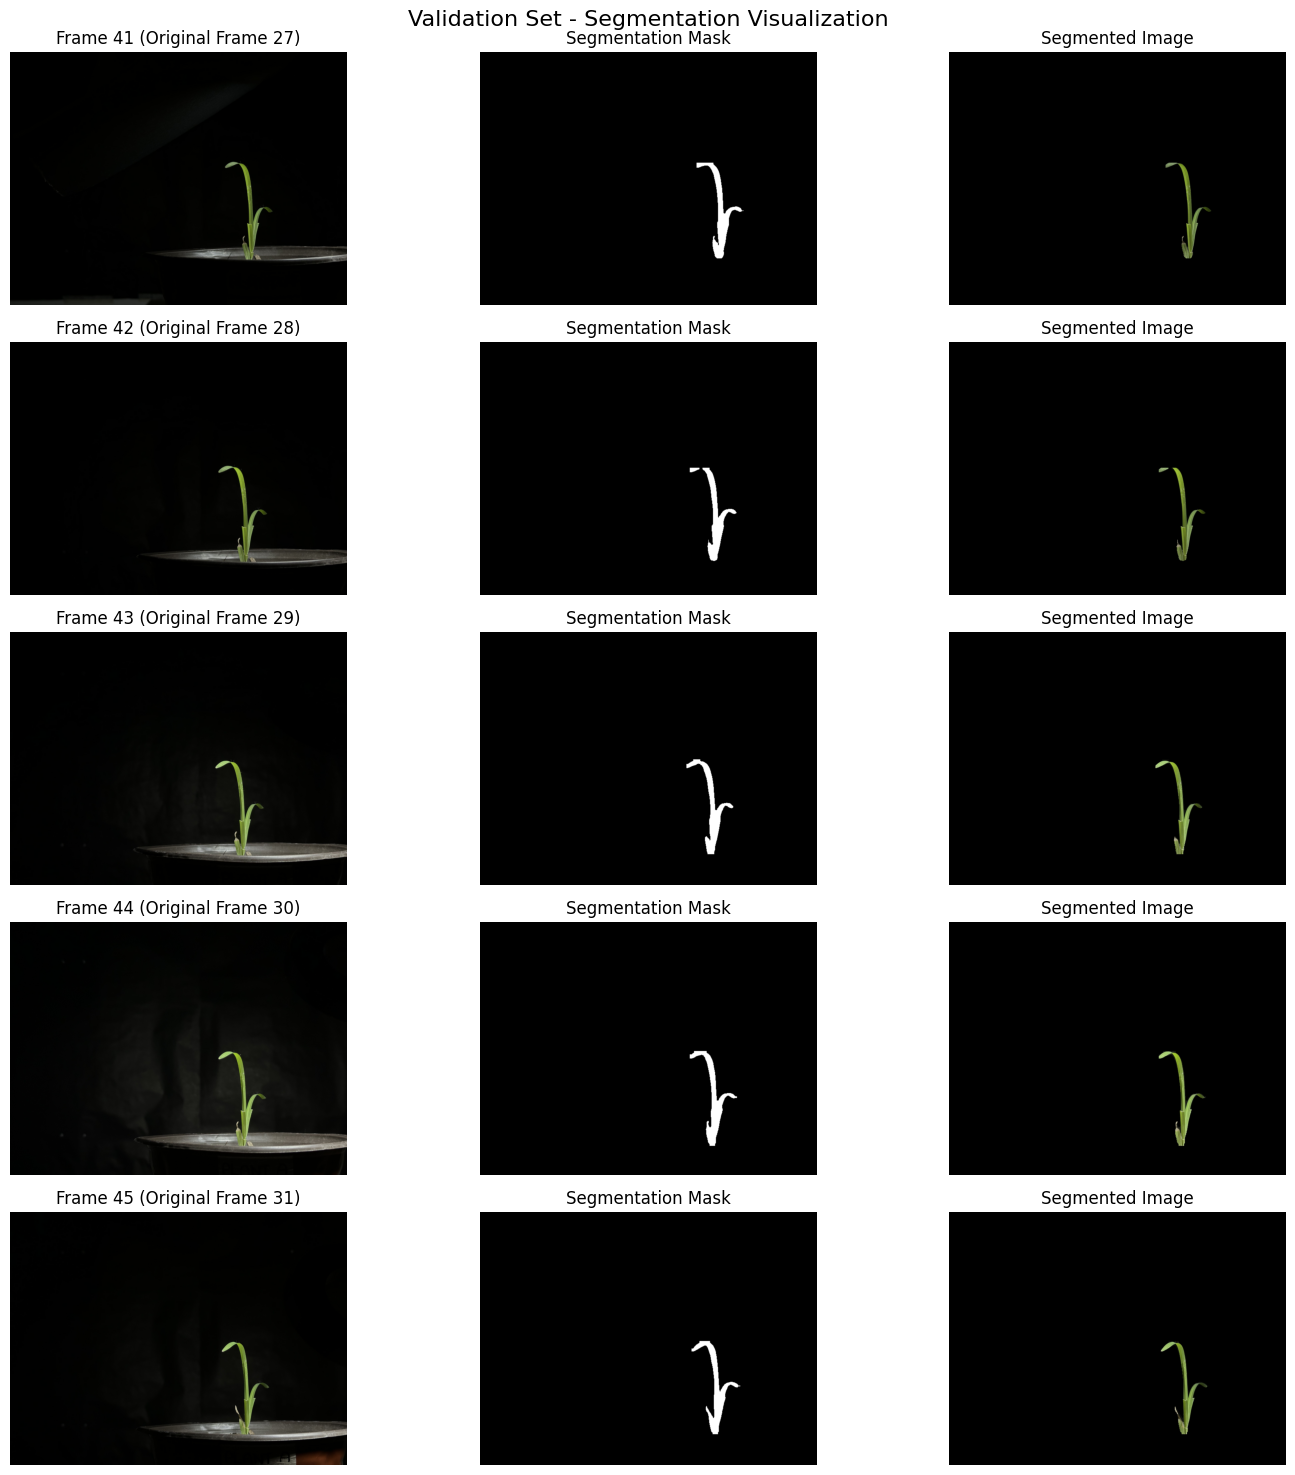

Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (

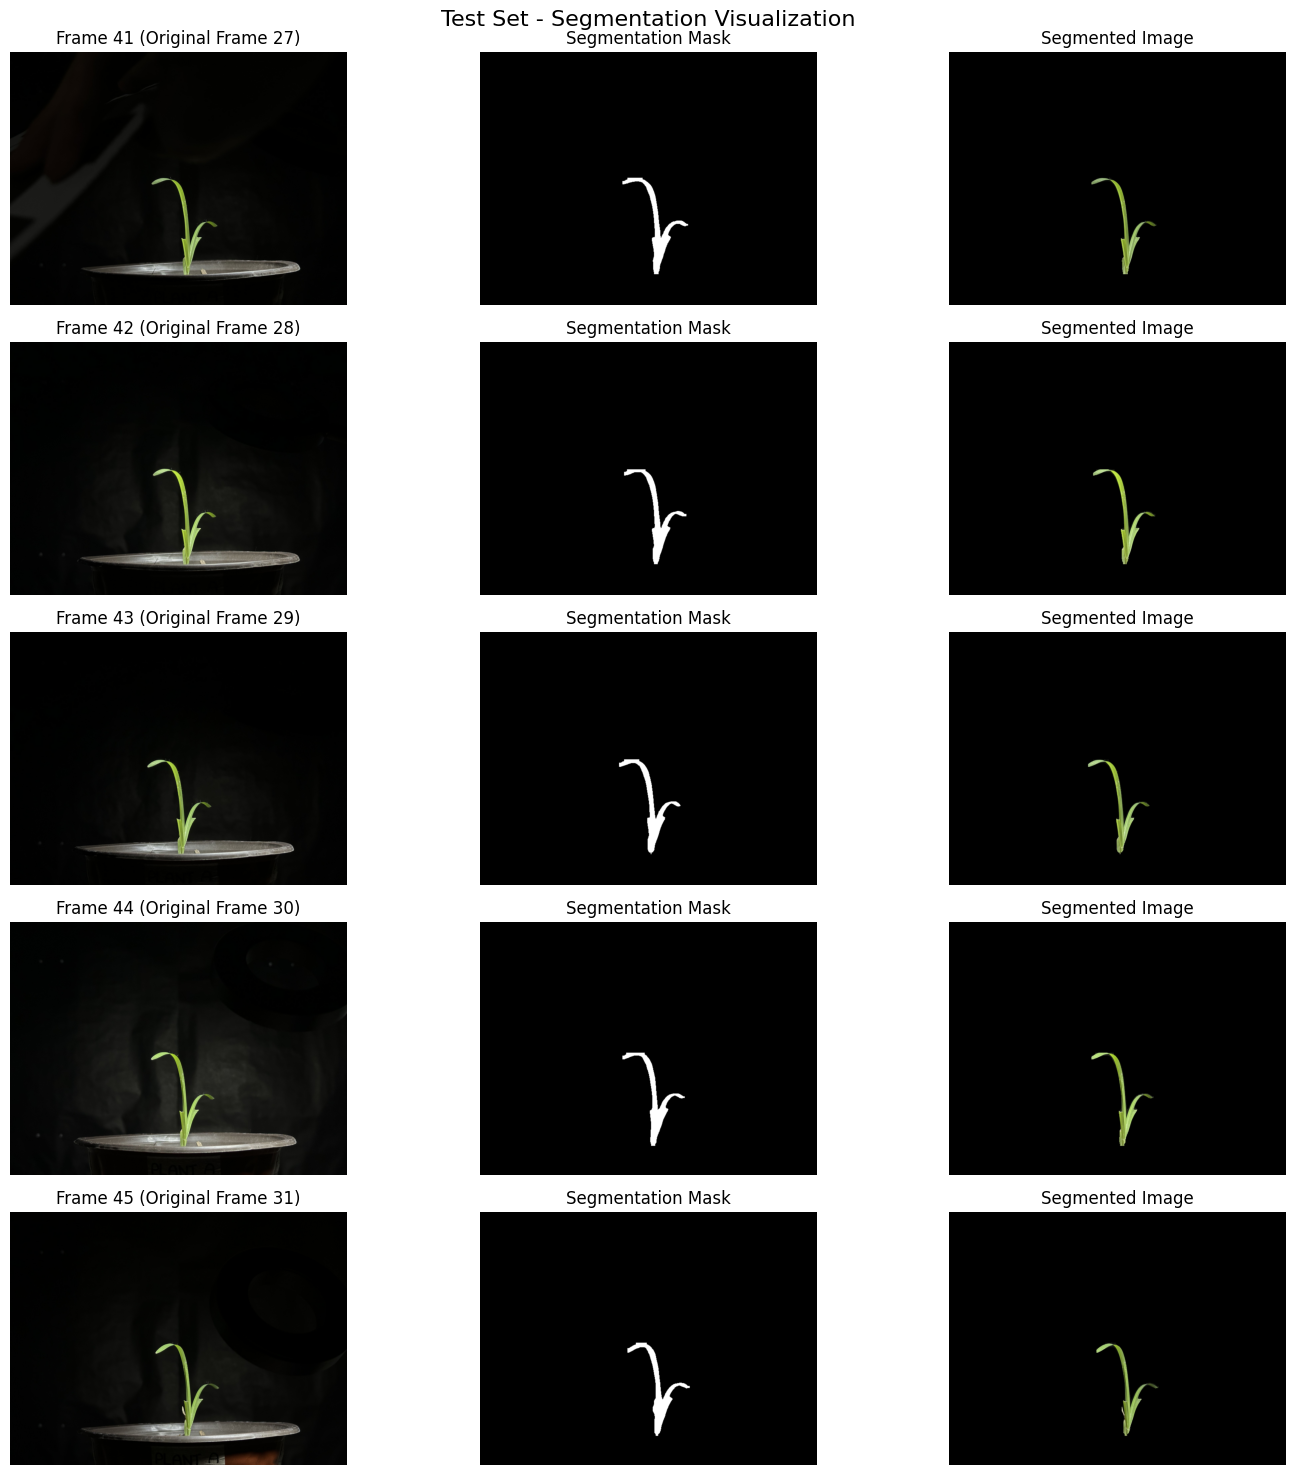

In [87]:
# Select sequences from each dataset (using the ones from prepadding step)
train_sequence = short_train_sequences[0]
val_sequence = short_val_sequences[0]
test_sequence = short_test_sequences[0]

# Visualize segmentation for the training set
visualize_segmentation(train_sequence, 'Training')

# Visualize segmentation for the validation set
visualize_segmentation(val_sequence, 'Validation')

# Visualize segmentation for the test set
visualize_segmentation(test_sequence, 'Test')

3. Resizing

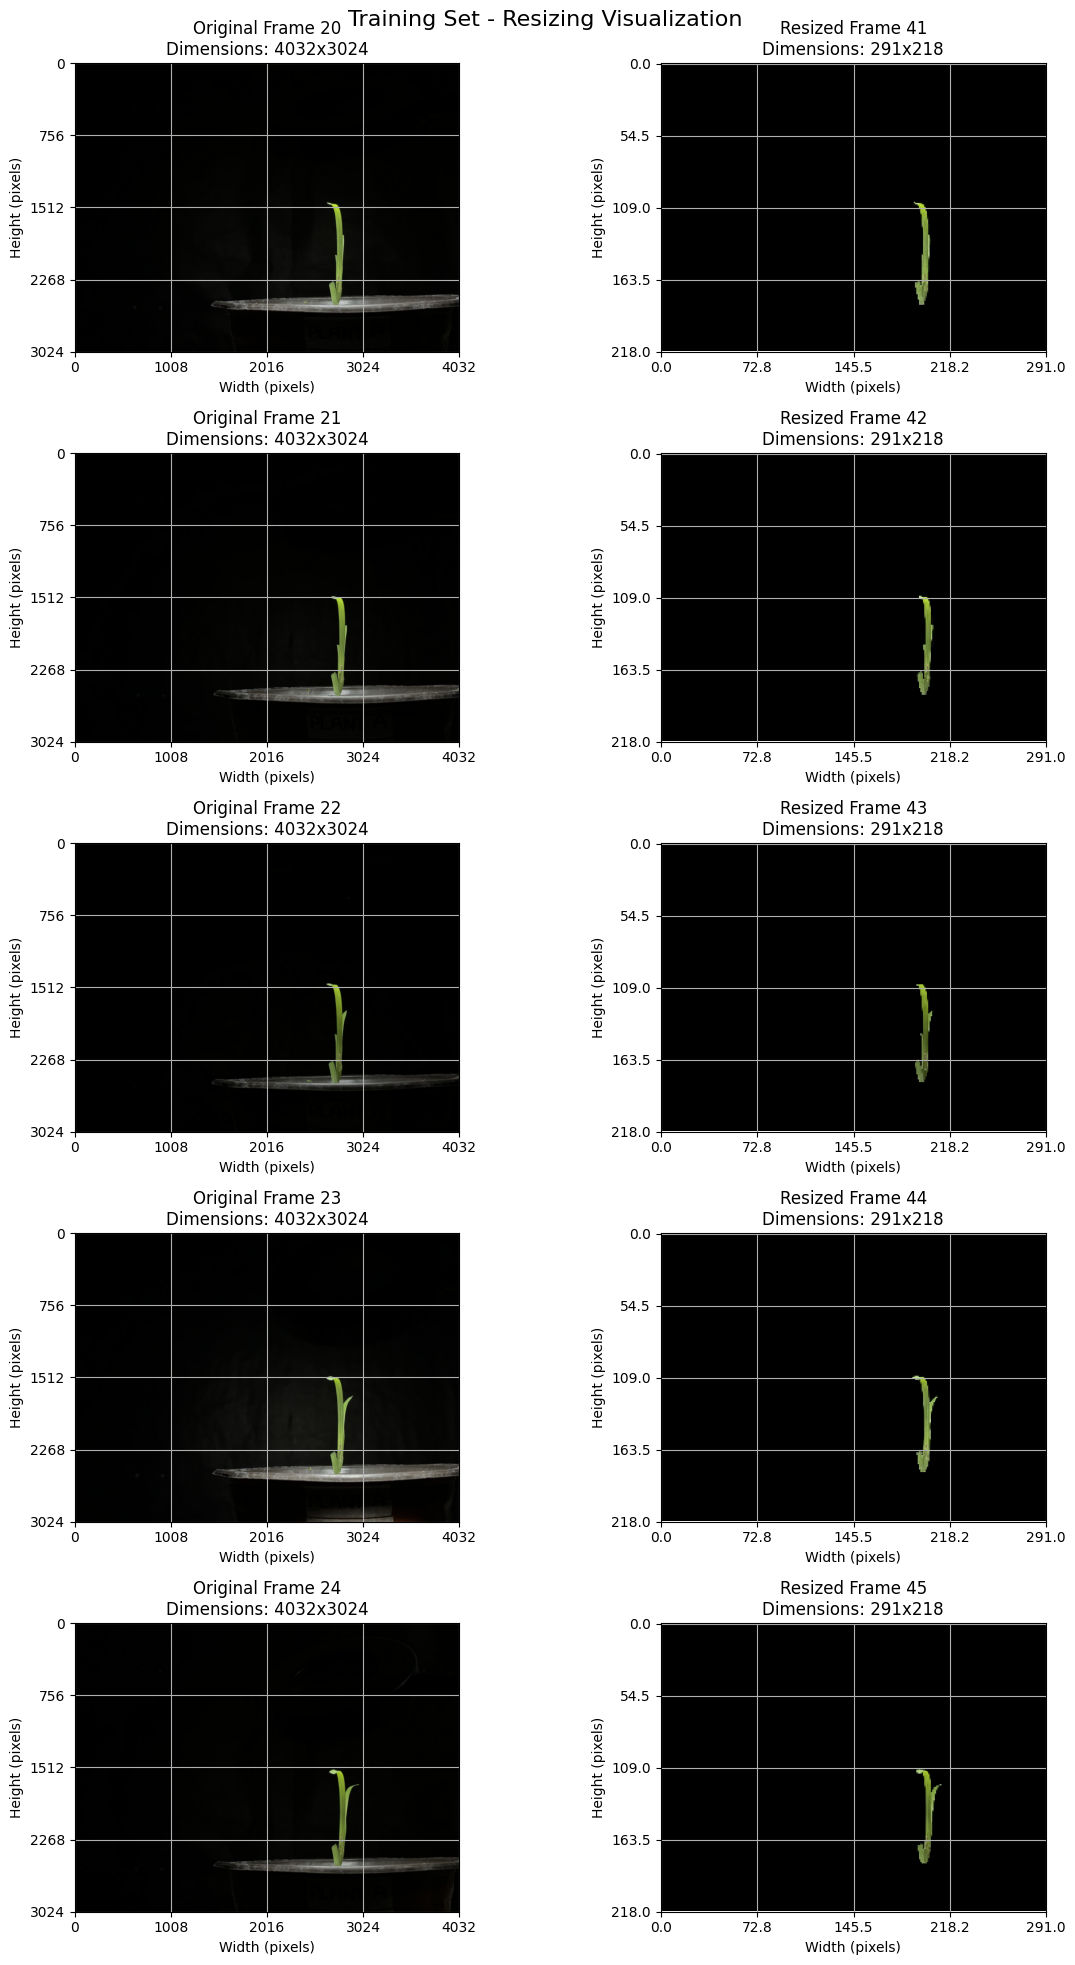

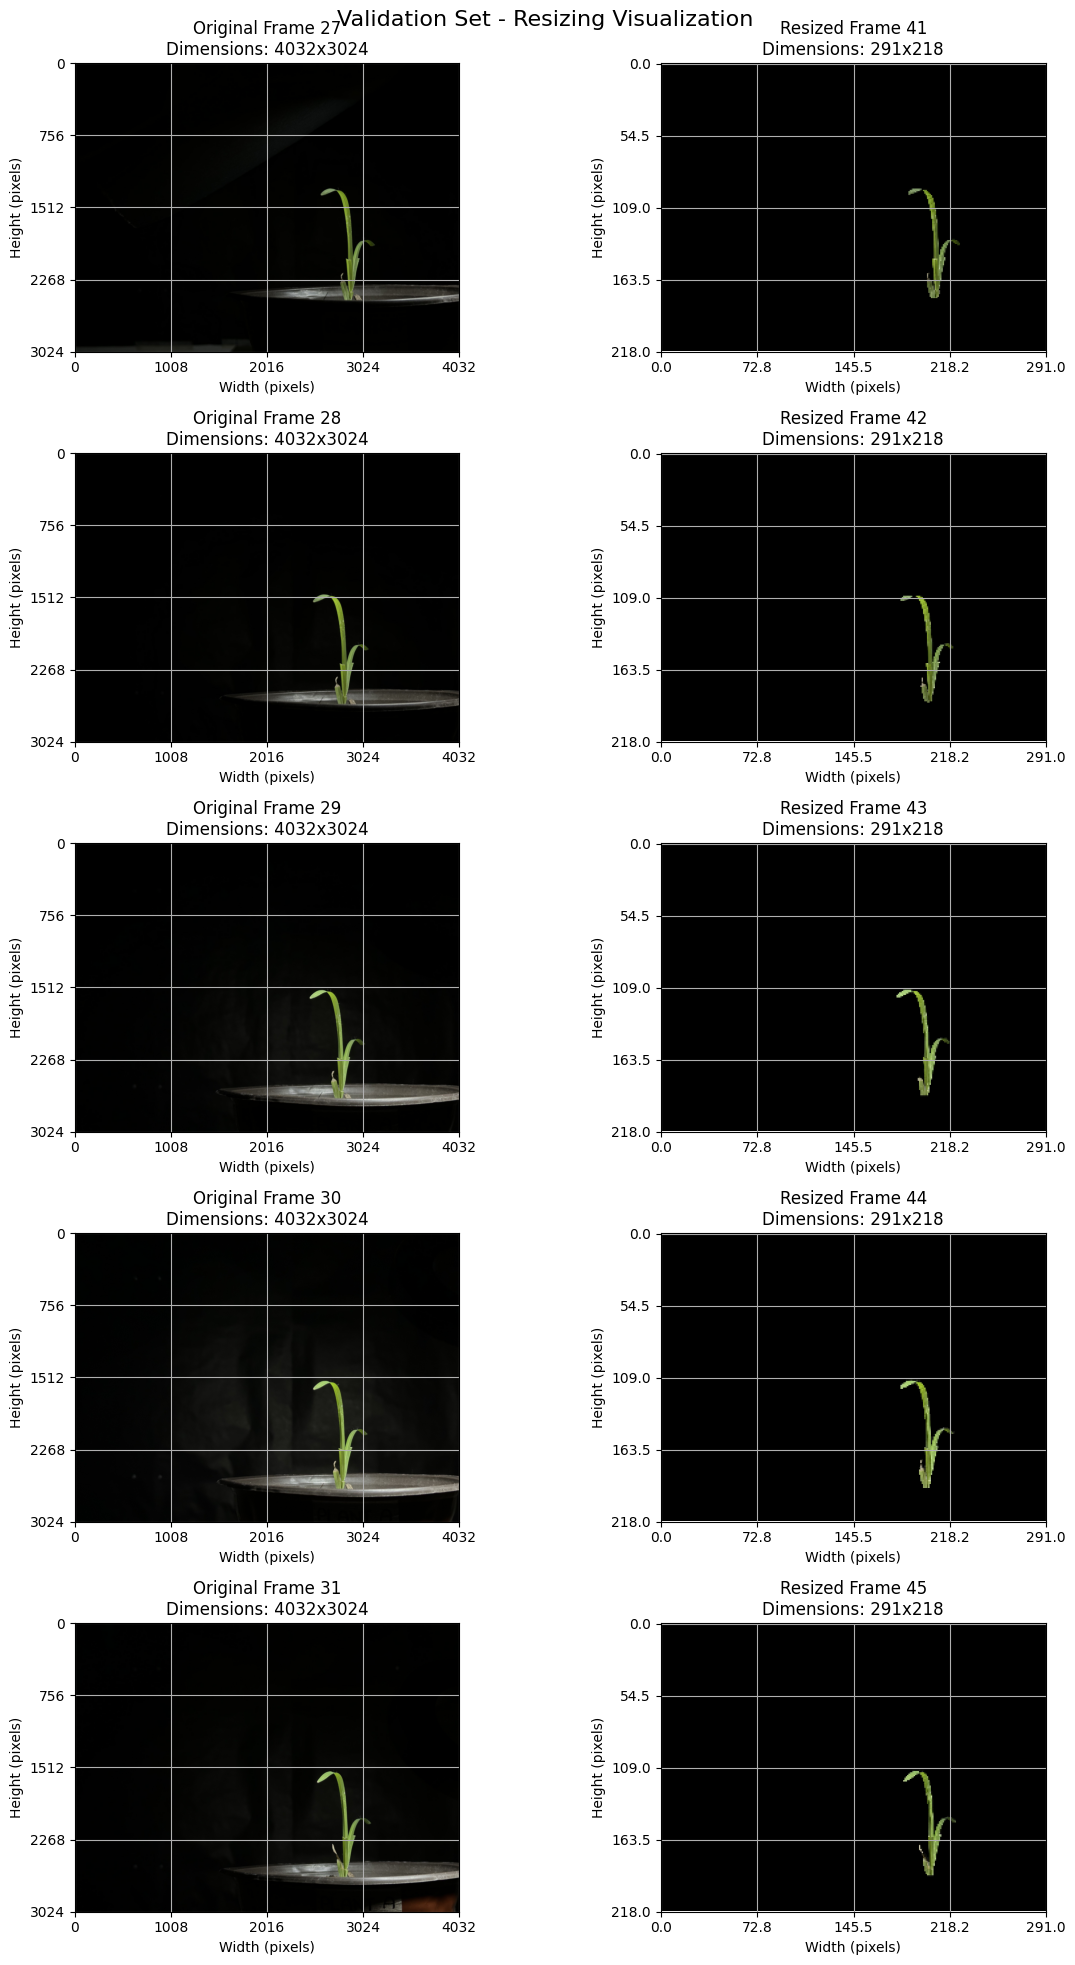

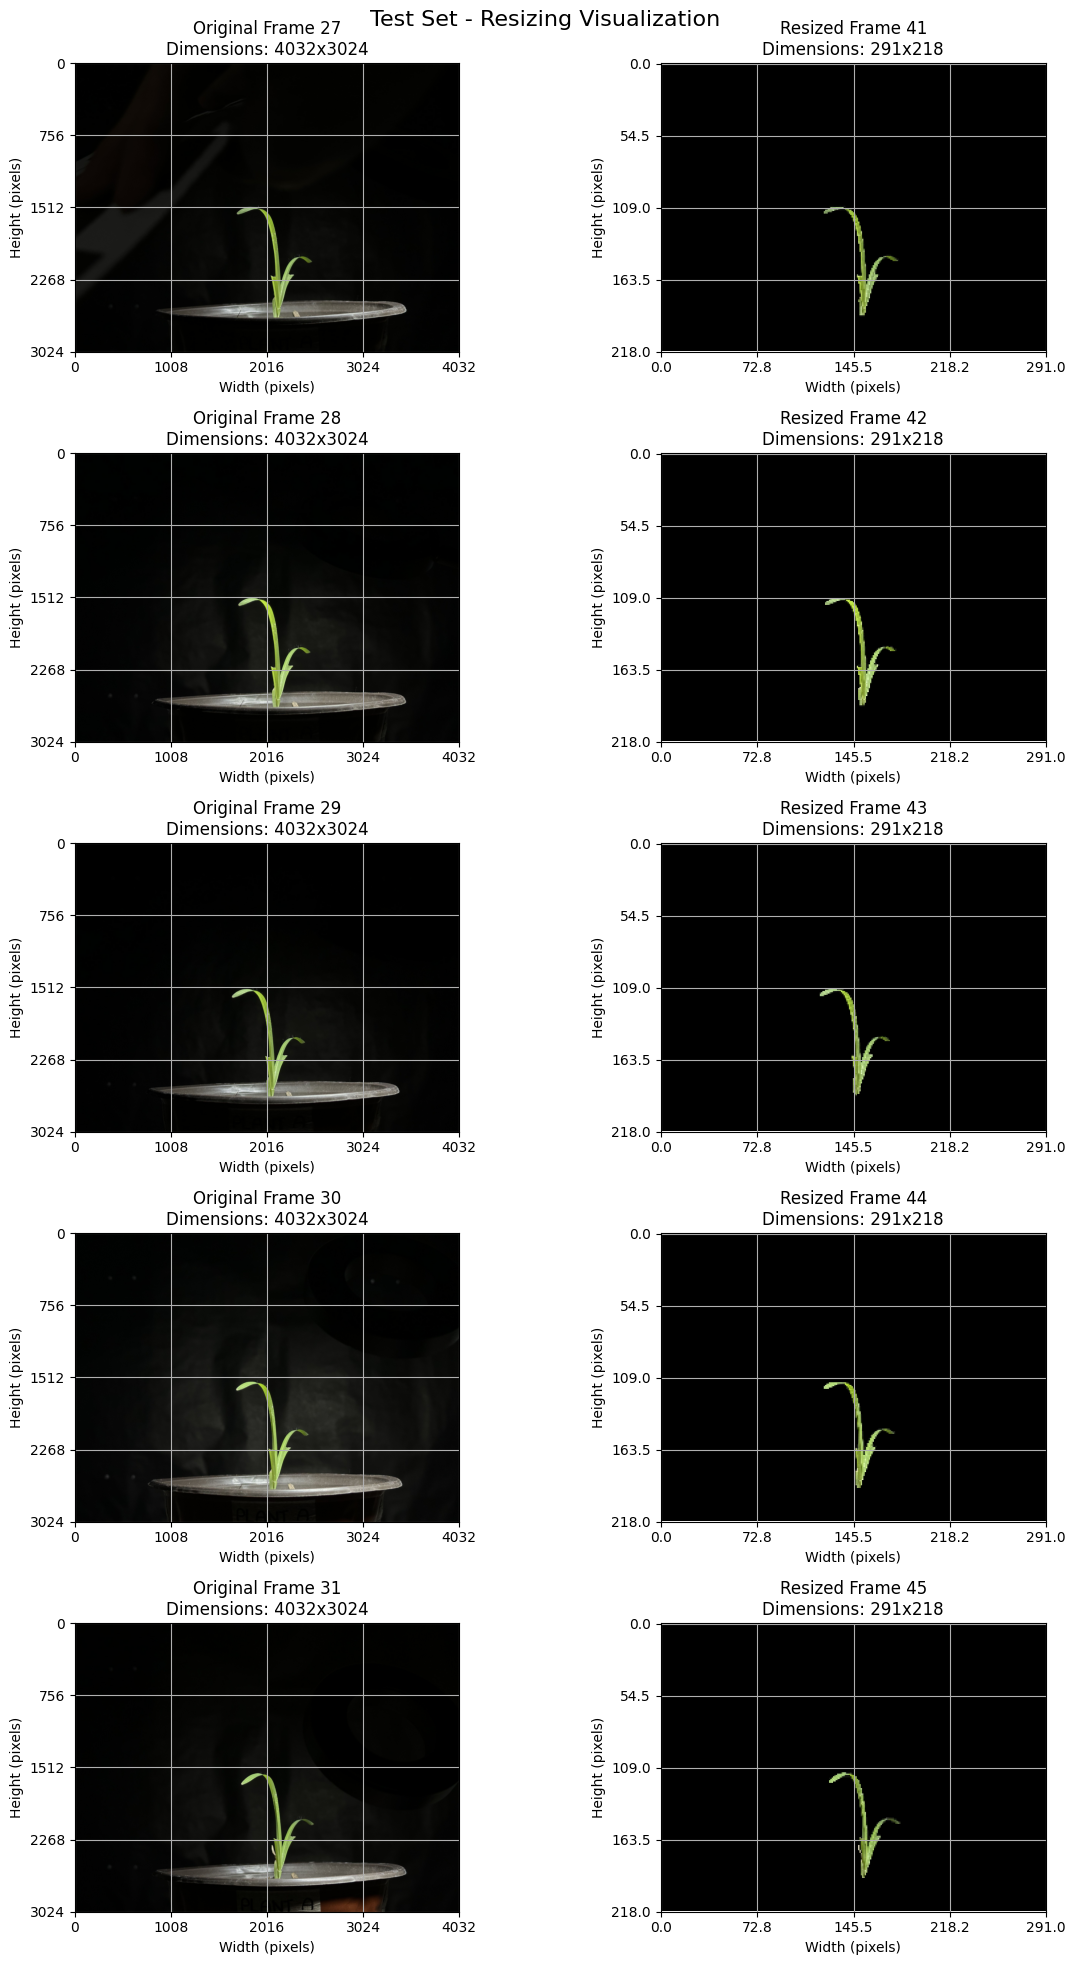

In [92]:
# Visualize resizing with dimensions for the training set
visualize_resizing_with_dimensions(train_sequence, 'Training')

# Visualize resizing with dimensions for the validation set
visualize_resizing_with_dimensions(val_sequence, 'Validation')

# Visualize resizing with dimensions for the test set
visualize_resizing_with_dimensions(test_sequence, 'Test')

4. Normalization


Training Set - Pixel Values at (200, 120):
Before Normalization: [        132         162          50]
After Normalization: [    0.51765     0.63529     0.19608]


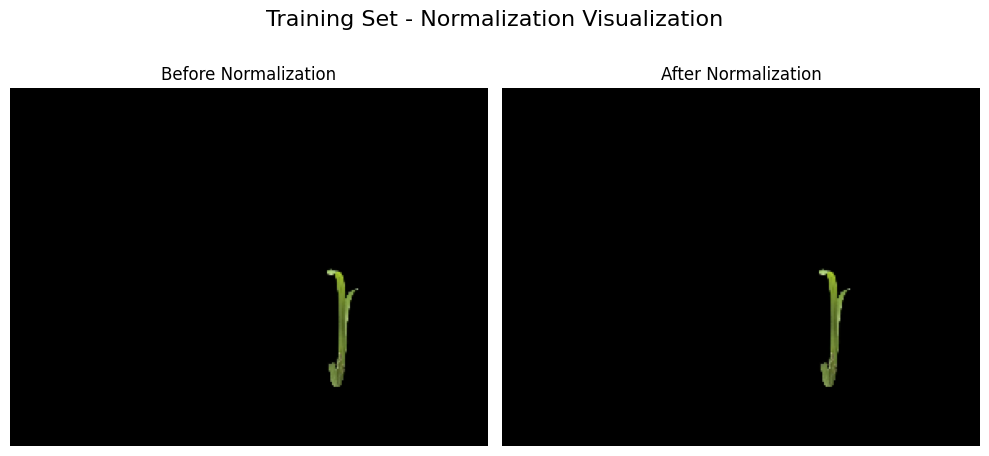


Validation Set - Pixel Values at (200, 120):
Before Normalization: [        111         138          42]
After Normalization: [    0.43529     0.54118     0.16471]


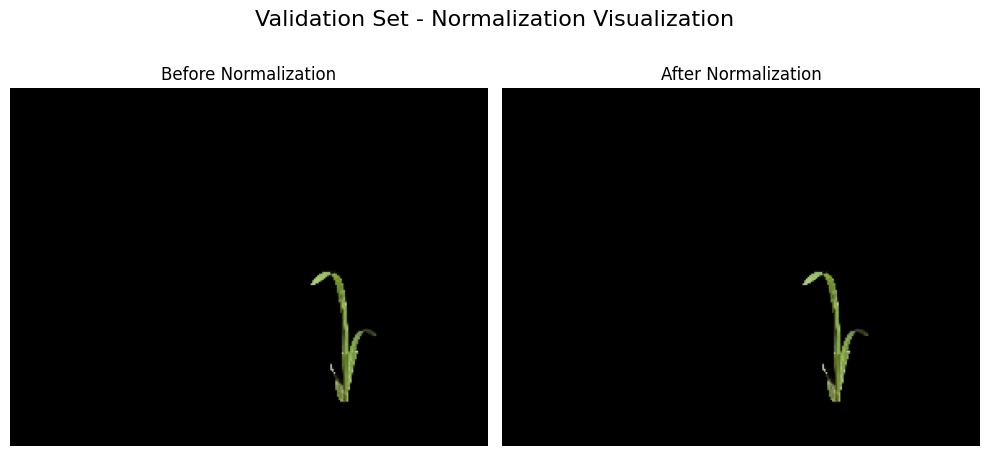


Test Set - Pixel Values at (200, 120):
Before Normalization: [          0           0           0]
After Normalization: [          0           0           0]


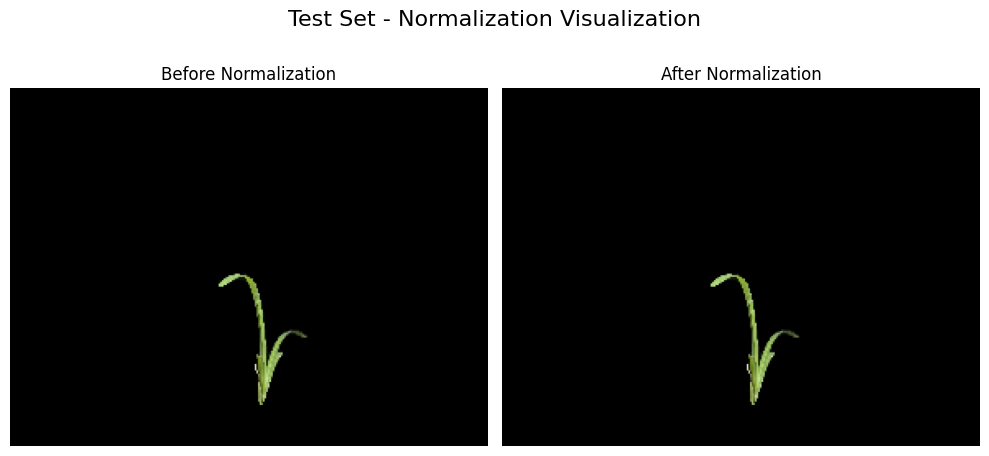

In [97]:
# Visualize normalization for the training set
visualize_normalization(train_sequence, 'Training')

# Visualize normalization for the validation set
visualize_normalization(val_sequence, 'Validation')

# Visualize normalization for the test set
visualize_normalization(test_sequence, 'Test')

5. Data augmentation

Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (3024, 4032)
Resizing mask from (608, 800) to (

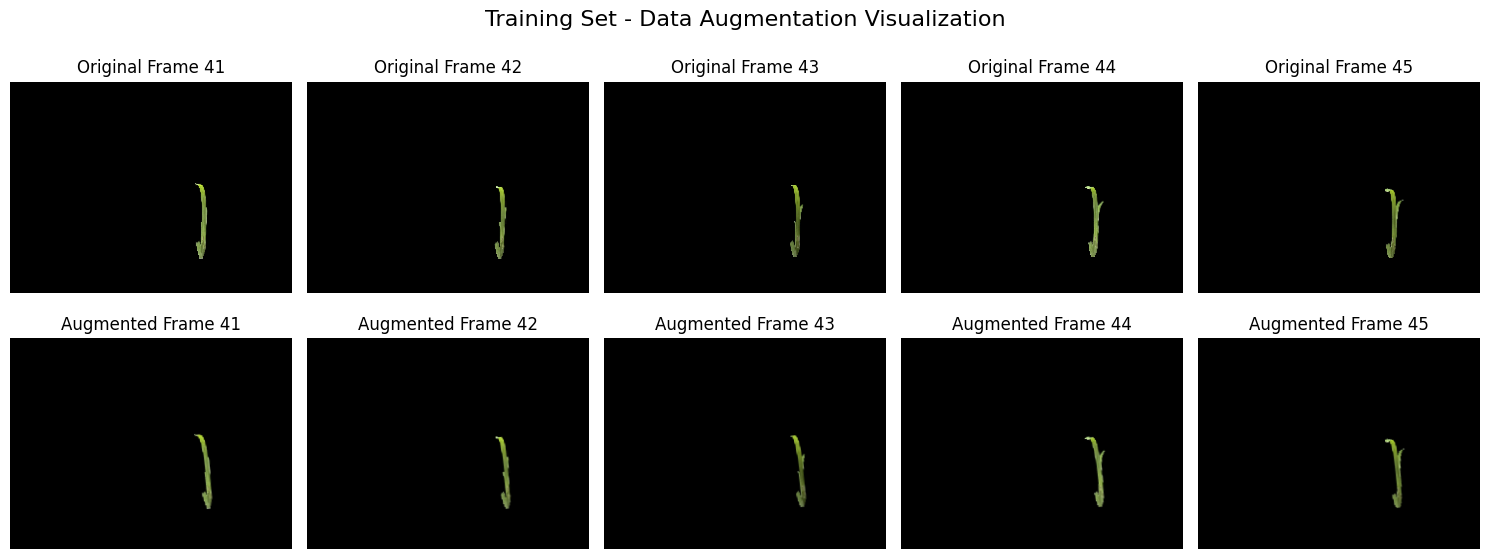

In [102]:
# Visualize data augmentation for the training set
visualize_data_augmentation(train_sequence, 'Training')

# Restore the original augmentation probability
AUGMENT_PROBABILITY = AUGMENT_PROBABILITY_TEMP

Verify shapes

In [109]:
# For the training dataset
print("Training Dataset Structure:")
print(train_dataset.element_spec)

# Similarly for validation and test datasets
print("\nValidation Dataset Structure:")
print(val_dataset.element_spec)

print("\nTest Dataset Structure:")
print(test_dataset.element_spec)

Training Dataset Structure:
(TensorSpec(shape=(None, 44, 218, 291, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 44, 218, 291, 3), dtype=tf.float32, name=None))

Validation Dataset Structure:
(TensorSpec(shape=(None, 44, 218, 291, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 44, 218, 291, 3), dtype=tf.float32, name=None))

Test Dataset Structure:
TensorSpec(shape=(None, 45, 218, 291, 3), dtype=tf.float32, name=None)


# Develop model

## *Iteration X*

### Build model

### Visualize model

### Compile model

### Train model

### Plot results

### Visualize results

## *Iteration 1*

### Build model

In [112]:
model = models.Sequential([
    layers.Input(shape=(None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    layers.ConvLSTM2D(
        filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
    ),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(
        filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
    ),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(
        filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
    ),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(
        filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
    ),
    layers.BatchNormalization(),
    layers.Conv3D(
        filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    ),
])

### Visualize model

In [113]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, None, 218, 291, 40)  │          62,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, None, 218, 291, 40)  │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, None, 218, 291, 40)  │         115,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, None, 218, 291, 40)  │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, None, 218, 291, 40)  │         115,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, None, 218, 291, 40)  │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, None, 218, 291, 40)  │         115,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, None, 218, 291, 40)  │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, None, 218, 291, 1)   │           1,081 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 409,881 (1.56 MB)

 Trainable params: 409,561 (1.56 MB)

 Non-trainable params: 320 (1.25 KB)

### Compile model

In [114]:
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

### Train model

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

### Quantitatively plot results (Accuracy and Loss Curves)

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Qualitatively visualize results

In [ ]:
# Select a sequence from the training set
example_sequence_paths = train_sequences[0]  # Adjust index as needed
example_sequence = preprocess_sequence(example_sequence_paths, MAX_SEQUENCE_LENGTH)

# Prepare inputs
example_input = example_sequence[:-1]  # Inputs
example_target = example_sequence[1:]  # Ground truth

# Expand dimensions to simulate batch size of 1
example_input = np.expand_dims(example_input, axis=0)  # Shape: (1, sequence_length, 40, 40, 1)

# Predict the sequence
predicted_sequence = model.predict(example_input)
predicted_sequence = predicted_sequence[0]  # Remove batch dimension

# Visualize the results
num_frames = 5  # Number of frames to display

plt.figure(figsize=(15, 6))

# Original frames
for i in range(num_frames):
    plt.subplot(2, num_frames, i + 1)
    plt.imshow(example_sequence[i])
    plt.title(f'Frame {i + 1} (Original)')
    plt.axis('off')

# Predicted frames
for i in range(num_frames):
    plt.subplot(2, num_frames, num_frames + i + 1)
    if i < 3:
        # Show original frames for the first 3 frames
        plt.imshow(example_sequence[i])
        plt.title(f'Frame {i + 1} (Original)')
    else:
        # Show predicted frames for subsequent frames
        plt.imshow(predicted_sequence[i])
        plt.title(f'Frame {i + 1} (Predicted)')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Quantitatively evaluate results (Weighted Coverage Score)

# Test model